In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import Delaunay
from sklearn.metrics.cluster import fowlkes_mallows_score
import vg
import plotly.graph_objects as go
import ray
from pytransform3d.rotations import matrix_from_axis_angle
from scipy.spatial.transform import Rotation as Rot
from tqdm import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import time
from numpy import transpose,array,hstack,arange,concatenate,eye,unique,dot,empty,append,ones,arccos
from numpy.linalg import norm
import warnings
warnings.filterwarnings('ignore')

def go_cluster(cluster):
    
    if(len(cluster.galaxies)==1):
        return [go.Scatter3d(
    x=cluster.galaxies[:,0],
    y=cluster.galaxies[:,1],
    z=cluster.galaxies[:,2],
    mode='markers',
    marker=dict(
        size=1,
        opacity=1,
        color='green'
    )
    )]
    
    return [go.Scatter3d(
    x=cluster.galaxies[:,0],
    y=cluster.galaxies[:,1],
    z=cluster.galaxies[:,2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=1,
        color='green'

    )
    )]+[cluster.get_mesh()]+[go.Scatter3d(
    x=[cluster.centroid[0]],
    y=[cluster.centroid[1]],
    z=[cluster.centroid[2]],
    mode='markers',
    marker=dict(
        size=2,
        opacity=1,
        color='red'
    )
    )]

def get_clusters_plot(clusters,is_show=False,filename='3d_model'):
    
    data=[]
    for cluster in clusters:
        data+=go_cluster(cluster)
    
    fig = go.Figure(data=data)

# tight layout
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    if(is_show):
        fig.show()
    fig.write_html(filename+".html")


C:\Users\shan2\Anaconda3\lib\site-packages\ray\autoscaler\_private\cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [2]:
coor=pd.read_csv('ra_dec_z_data.csv')
coor_with_labels=pd.read_csv('coor_with_labels.csv')

In [24]:
tmp_coor_with_labels=coor_with_labels[['x','y','z','label']]
tmp_coor_with_labels=tmp_coor_with_labels[tmp_coor_with_labels.x.between(40, 120)]
tmp_coor_with_labels=tmp_coor_with_labels[tmp_coor_with_labels.y.between(-20, 20)]
tmp_coor_with_labels=tmp_coor_with_labels[tmp_coor_with_labels.z.between(-20, 20)]

tmp_coor_with_labels.shape

(485, 4)

In [51]:
tmp_coor=coor[['x','y','z']]
tmp_coor=tmp_coor[tmp_coor.x.between(-13, 13)]
tmp_coor=tmp_coor[tmp_coor.y.between(-13, 13)]
tmp_coor=tmp_coor[tmp_coor.z.between(-13, 13)]
tmp_coor.shape

(13839, 3)

array([[-7.68263678, -7.98226963, -4.04490746],
       [ 3.35635023,  6.46321007, -2.08154364],
       [ 9.23985366, -2.98237003, -0.10209136],
       ...,
       [ 0.66807282,  4.63696306, -8.45742126],
       [ 0.34071255, -0.09669052,  0.32841983],
       [-0.88717063,  1.17225613, -1.31706078]])

(array([27809., 14432., 27275., 37364., 45496., 44351., 45898., 52018.,
        53442., 58992., 63190., 63565., 61294., 50393., 47756., 50654.,
        52357., 51230., 45909., 46014., 48284., 42618., 37431., 36571.,
        32511., 31740., 27915., 28507., 27078., 26360., 23838., 23046.,
        21221., 21288., 20528., 19668., 19278., 18948., 17546., 16333.,
        17083., 16775., 16858., 17045., 16218., 16323., 16680., 17365.,
        17999., 18141.]),
 array([5.00383585e-03, 3.20552456e+01, 6.41054873e+01, 9.61557291e+01,
        1.28205971e+02, 1.60256213e+02, 1.92306454e+02, 2.24356696e+02,
        2.56406938e+02, 2.88457180e+02, 3.20507421e+02, 3.52557663e+02,
        3.84607905e+02, 4.16658147e+02, 4.48708388e+02, 4.80758630e+02,
        5.12808872e+02, 5.44859114e+02, 5.76909355e+02, 6.08959597e+02,
        6.41009839e+02, 6.73060081e+02, 7.05110322e+02, 7.37160564e+02,
        7.69210806e+02, 8.01261048e+02, 8.33311289e+02, 8.65361531e+02,
        8.97411773e+02, 9.29462015e+02

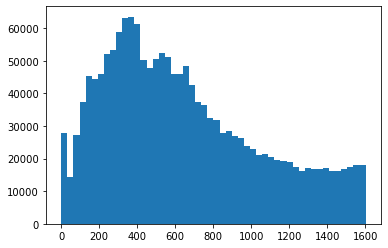

In [18]:
plt.hist(np.linalg.norm(coor[['x','y','z']].to_numpy(), axis = 1),bins = 50)

In [52]:
class Cluster():
    # non shifted shape, easy to expand
    non_rotated_cube= None
    rotated_cube=None# shifted coor of rotated cube
    centroid=None# coor of center
    galaxies=None

    is_complete=False
    times_grow=0
    '''
    center - coordinates of center of cluster (in case on sigle galaxy coordinates on galaxy)
    non_rotated_cube - coordinates of non rotated parallelepiped that fits to cluster
    galaxies - coordinates on galaxies
    init_length - ration on longer part of parallelepiped to shorters
    '''
    def __init__(self, center,non_rotated_cube=None,galaxies=None, init_length=10):
        
        tmp_l= [0, 0, 0, 0, 1, 1, 1, 1]
        self.non_rotated_cube = (transpose(array([[0, 0, 1, 1, 0, 0, 1, 1],[0, 1, 1, 0, 0, 1, 1, 0],
                                                  [element * init_length for element in tmp_l]]))-array([0.5,0.5,0.5*init_length]))*0.05
        
        if(isinstance(non_rotated_cube, np.ndarray)):
            self.non_rotated_cube=non_rotated_cube
        if(not isinstance(galaxies, np.ndarray)):
            self.galaxies=array([center])
        else:
            self.galaxies=array(galaxies)
        
        self.centroid=center[:3]
        self.rotated_cube = self.rotate(self.centroid,self.non_rotated_cube)+self.centroid
        
        for gal in self.galaxies:
            if(Delaunay(self.rotated_cube).find_simplex(gal[:3]) < 0):
                raise ValueError
        
        
    def rotate(self, vector, points):    
        vector = vg.normalize(vector)
        axis = vg.perpendicular(vg.basis.z, vector)
        angle = vg.angle(vg.basis.z, vector, units='rad')
        
        a = hstack((axis, (angle,)))
        R = matrix_from_axis_angle(a)
        
        r = Rot.from_matrix(R)
        rotmat = r.apply(points)
        
        return rotmat

    def get_mesh(self):
        return go.Mesh3d(
        x=self.rotated_cube[:,0],
        y=self.rotated_cube[:,1],
        z=self.rotated_cube[:,2],
        opacity=0.5,
        i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
        j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
        k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],color='blue'
        )
    
    def grow(self,coef):
        if(self.times_grow==5):
            self.is_complete=True
            return
        self.times_grow+=1
        self.non_rotated_cube=self.non_rotated_cube*coef
        self.rotated_cube = self.rotate(self.centroid,self.non_rotated_cube)+self.centroid            
    
class Clusterer:
    
    unit_cube=(transpose(array([[0, 0, 1, 1, 0, 0, 1, 1],[0, 1, 1, 0, 0, 1, 1, 0],[0, 0, 0, 0, 1, 1, 1, 1]]))-0.5)
    init_cluster_length = None
    coefs = 0
    
    '''
        init_length - ration on longer part of parallelepiped to shorters
        coefs - array of coefs to steps of algo
    '''
    def __init__(self,init_cluster_length=10, coefs = 1+1/arange(1,100)[15:]*5):
        self.clusters=[]
        self.init_cluster_length = init_cluster_length
        self.coefs = coefs
        ray.init(log_to_driver=False)
    
    def merge(self):
        
        clusters_len=len(self.clusters)


        clusters_id = ray.put(self.clusters)

        graph=ray.get([self.parallel_connectivity_matrix.remote(self,clusters_id, subset) for subset in self.split_array(arange(len(self.clusters)),4)])

        graph = concatenate( graph, axis=0 )
        graph = graph+transpose(graph)
        graph=graph-eye(len(self.clusters))

        graph = csr_matrix(graph)
        n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
        
        components=[]
        
        np_clusters=array(self.clusters)
        
        components=[np_clusters[labels==label]  for label in unique(labels) ]
 
        new_clusters=list(map(self.collide_clusters,components))

        self.clusters=new_clusters        
      
        
    def check_collision(self,a:Cluster, b: Cluster):      
        i=a.rotated_cube[1]-a.rotated_cube[0]
        j=a.rotated_cube[3]-a.rotated_cube[0]
        k=a.rotated_cube[4]-a.rotated_cube[0]
        for point in b.rotated_cube:
            u=point-a.rotated_cube[0]
            u_i,u_j,u_k=dot(u,i),dot(u,j),dot(u,k)
            if((0<= u_i)and(0<= u_j)and(0<= u_k)and
               (u_i <= dot(i,i))and(u_j <= dot(j,j))and(u_k <= dot(k,k))):
                return True
            
        i=b.rotated_cube[1]-b.rotated_cube[0]
        j=b.rotated_cube[3]-b.rotated_cube[0]
        k=b.rotated_cube[4]-b.rotated_cube[0]
        for point in a.rotated_cube:
            u=point-b.rotated_cube[0]
            u_i,u_j,u_k=dot(u,i),dot(u,j),dot(u,k)
            if((0<= u_i)and(0<= u_j)and(0<= u_k)and
               (u_i <= dot(i,i))and(u_j <= dot(j,j))and(u_k <= dot(k,k))):
                return True
        return False
 
    def collide_clusters(self, clusters:[Cluster]):
        
        if(len(clusters)==1):
            return clusters[0]
        galaxies=[cluster.galaxies for cluster in clusters]
        vertex_points=[cluster.rotated_cube for cluster in clusters]

        galaxies=concatenate( galaxies, axis=0 )
        vertex_points=concatenate( vertex_points, axis=0 )
        
        center = galaxies[:,:3].mean(axis=0)

        projections = center * dot(galaxies[:,:3], transpose([center])) / dot(center, center)
        
        distances_on_line=norm(projections-center,axis=1)
        vectors_from_line=galaxies[:,:3]-projections
    
        length = distances_on_line.max()
        width=norm(vectors_from_line,axis=1).max()
    
        cube=self.unit_cube.copy()*[width*2+0.05,width*2+0.05,length*2+0.05]
    
        return Cluster(center,cube,galaxies,self.init_cluster_length)
            
    def compress_cluster(self,cluster):

        galaxies=cluster.galaxies
        if(galaxies.ndim==1 ):
            galaxies=array([galaxies])
        vertex_points=cluster.rotated_cube
        
        center = galaxies[:,:3].mean(axis=0)

        projections = center * dot(galaxies[:,:3], transpose([center])) / dot(center, center)
        
        distances_on_line=norm(projections-center,axis=1)
        vectors_from_line=galaxies[:,:3]-projections
    
        length = distances_on_line.max()
        width=norm(vectors_from_line,axis=1).max()
    
        cube=self.unit_cube.copy()*[width*2+0.05,width*2+0.05,length*2+0.05]
    
        return Cluster(center,cube,galaxies,self.init_cluster_length)
    
    def step(self,grow_coef):
        
        is_done=True
        for cluster in self.clusters:
            if(not cluster.is_complete):
                is_done=False
                break
                
        if (is_done):
            return False
        
        for cluster in self.clusters:
            cluster.grow(1+(grow_coef-1)/ (1 + cluster.times_grow/5 + len(cluster.galaxies)/10))
        self.merge()
        return True
      
    def split_array(self,a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))
    
    @ray.remote
    def parallel_connectivity_matrix(self,clusters ,rows):
        new_graph=empty((len(rows),len(clusters)))
        for i in range(len(rows)):
            for j in range(rows[i],len(clusters)):
                cluster_j=clusters[j]
                cluster_i=clusters[rows[i]]
                if(norm(cluster_i.centroid-cluster_j.centroid)>8):
                    continue 

                if(arccos((dot(cluster_i.centroid, cluster_j.centroid) / (norm(cluster_i.centroid) * norm(cluster_j.centroid))))>0.01):
                    continue

                if(self.check_collision(cluster_i,cluster_j)):
                    new_graph[i,j]=1
        return new_graph
    
    def fit(self,data):
        data_np=array(data)
        self.clusters=[Cluster(append(data_np[i],i), init_length = self.init_cluster_length) for i in range(len(data_np)) ]
        iter_num=1
        start = time.time()
        while(self.step(self.coefs[iter_num-1])):
            print('iter : ',iter_num,', n_clusters: ', len(self.clusters),', time: ',time.time()-start,' s')
            iter_num+=1
            start = time.time()
        
        galaxies=[]


        galaxies=[append(self.clusters[i].galaxies, ones((len(self.clusters[i].galaxies),1))*i , axis=1) for i in range(len(self.clusters))]
        self.clusters=[self.compress_cluster(cluster) for cluster in self.clusters]
        galaxies=concatenate(galaxies)
        galaxies = galaxies[galaxies[:,3].argsort()]  
        return galaxies[:,4]
        

In [54]:
%%time
clusterer=Clusterer(init_cluster_length=5,coefs = 1+1/arange(1,100)[10:]*5)
labels=clusterer.fit(tmp_coor[['x','y','z']])
# print(fowlkes_mallows_score(tmp_coor_with_labels['label'],labels))
ray.shutdown()
get_clusters_plot(clusterer.clusters)
np.save('labes.npy', labels)

2021-09-20 23:23:06,913	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


KeyboardInterrupt: 

In [53]:
ray.shutdown()


In [24]:
import hdbscan
model=hdbscan.HDBSCAN().fit(tmp_coor_with_labels[['x','y','z']])
labels =model.labels_
c=1
for i in range(len(labels)):
    if(labels[i]==-1):
        labels[i]=400000+c
        c+=1
print(fowlkes_mallows_score(tmp_coor_with_labels['label'],labels))

0.17616944205911042


In [7]:
def compress_cluster(galaxies):

    galaxies=galaxies
    if(galaxies.ndim==1 ):
        galaxies=array([galaxies])
    
    center = galaxies[:,:3].mean(axis=0)

    projections = center * dot(galaxies[:,:3], transpose([center])) / dot(center, center)
    
    distances_on_line=norm(projections-center,axis=1)
    vectors_from_line=galaxies[:,:3]-projections

    length = distances_on_line.max()
    width=norm(vectors_from_line,axis=1).max()

    cube=(transpose(array([[0, 0, 1, 1, 0, 0, 1, 1],[0, 1, 1, 0, 0, 1, 1, 0],[0, 0, 0, 0, 1, 1, 1, 1]]))-0.5)*[width*2+0.05,width*2+0.05,length*2+0.05]

    return Cluster(center,cube,galaxies)

In [8]:
gals=[tmp_coor_with_labels[tmp_coor_with_labels['label']==label][['x','y','z']].to_numpy() for label in tmp_coor_with_labels['label'].unique()]
clus=list(map(compress_cluster,gals))
angle_list=[]
for cluster_i in clus:
    min_angle=1
    for cluster_j in clus:
        if(norm(cluster_i.centroid-cluster_j.centroid)>3):
            continue
        new_min=arccos((dot(cluster_i.centroid, cluster_j.centroid) / (norm(cluster_i.centroid) * norm(cluster_j.centroid))))
        if((new_min<min_angle) and (new_min!=0) ):
            min_angle=new_min
    if(min_angle<0.5):
        angle_list.append(min_angle)
print(min_angle)


NameError: name 'Cluster' is not defined

In [27]:
gals=[tmp_coor_with_labels[tmp_coor_with_labels['label']==label][['x','y','z']].to_numpy() for label in tmp_coor_with_labels['label'].unique()]
clus=list(map(compress_cluster,gals))

data=[]
for cluster in clus:
    data+=go_cluster(cluster)
    
for i in tmp_coor.to_numpy():
    data+= [go.Scatter3d(
    x=[i[0]],
    y=[i[1]],
    z=[i[2]],
    mode='markers',
    marker=dict(
        size=2,
        opacity=1,
        color='orange'
    )
    )]


fig = go.Figure(data=data)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.write_html('true (40,120,-20,20,-20,20)'+".html")


NameError: name 'data' is not defined

In [ ]:
plt.hist(angle_list,bins=100)

In [13]:
tmp_coor_with_labels['label'].value_counts().value_counts()

1      2248
2       392
3       121
4        54
5        37
6        20
8        15
9        10
7         8
10        7
13        7
14        5
12        4
18        3
15        3
11        3
19        2
50        2
17        2
42        1
72        1
38        1
28        1
26        1
22        1
20        1
16        1
231       1
Name: label, dtype: int64

In [14]:
pd.Series(labels).value_counts().value_counts()

1     3189
2      411
3       88
4       55
5       35
6       13
7       10
9        9
10       8
8        6
12       2
11       2
19       2
22       1
18       1
16       1
13       1
15       1
17       1
23       1
25       1
dtype: int64